# Neural Networks

<img src="figure6.png" width="700">

All PyTorch-provided subclasses of nn.Module have their \__call__ method defined.
This allows us to instantiate an nn.Linear and call it as if it was a function

Calling an instance of nn.Module with a set of arguments ends up calling a method
named forward with the same arguments. The forward method is what executes the
forward computation, while \__call__ does other rather important chores before and
after calling forward. So, it is technically possible to call forward directly, and it will
produce the same output as \__call__, but this should not be done from user code:

```python
y = model(x) # Correct!
y = model.forward(x) # Wrong


```python
def __call__(self, *input, **kwargs):
    for hook in self._forward_pre_hooks.values():
        hook(self, input)
    result = self.forward(*input, **kwargs)
    for hook in self._forward_hooks.values():
        hook_result = hook(self, input, result)
        # ...
    for hook in self._backward_hooks.values():
        # ...
    return result

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

In [13]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [14]:
print(t_c.shape)
print(t_u.shape)

torch.Size([11])
torch.Size([11])


In [15]:
t_c = t_c.unsqueeze(1) # Add extra dimension at axis 1
t_u = t_u.unsqueeze(1)

In [16]:
print(t_c.shape)
print(t_u.shape)

torch.Size([11, 1])
torch.Size([11, 1])


Implementing the linear model using torch.nn 
```python
def linear_model(t_u, w, b):
    return t_u * w + b

In [19]:
linear_model = nn.Linear(1, 1)

In [24]:
optimizer = optim.SGD(linear_model.parameters(), 
                      lr=1e-2)

In [27]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 3,  4, 10,  9,  5,  2,  7,  8,  6]), tensor([1, 0]))

In [28]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u # Normalizing by multiplying for 0.1
val_t_un = 0.1 * val_t_u

## Training loop 

The model is now
passed in, instead of
the individual params. This is beacuse we don’t need to pass params explicitly to
model since the model itself holds its Parameters internally.

We can also replace our hand-written loss with the ones available in torch.

In [29]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
    t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
    
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        
        loss_train.backward()
        optimizer.step()
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f}," f" Validation loss {loss_val.item():.4f}")

In [32]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
            n_epochs = 3000,
            optimizer = optimizer,
            model = linear_model,
            loss_fn = nn.MSELoss(), # Using the already implemented loss
            t_u_train = train_t_un,
            t_u_val = val_t_un,
            t_c_train = train_t_c,
            t_c_val = val_t_c)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 281.9807, Validation loss 141.8073
Epoch 1000, Training loss 3.8751, Validation loss 4.2222
Epoch 2000, Training loss 3.1742, Validation loss 2.3587
Epoch 3000, Training loss 3.1538, Validation loss 2.1235

Parameter containing:
tensor([[5.2464]], requires_grad=True)
Parameter containing:
tensor([-16.6462], requires_grad=True)


### Neural Newtork instead of Linear Model

In [53]:
seq_model = nn.Sequential(
                nn.Linear(1, 13), # 13 Hidden features
                nn.Tanh(),
                nn.Linear(13, 1)
)

In [54]:
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [55]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [56]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [57]:
from collections import OrderedDict

seq_model = nn.Sequential(
                OrderedDict([
                    ('hidden_linear', nn.Linear(1, 8)),
                    ('hidden_activation', nn.Tanh()),
                    ('output_linear', nn.Linear(8, 1))
                ]))

In [58]:
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [59]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [60]:
seq_model.hidden_linear.bias

Parameter containing:
tensor([-0.1482,  0.1519,  0.7363, -0.4480,  0.4427,  0.5136,  0.2019,  0.7804],
       requires_grad=True)

In [61]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
            n_epochs = 5000,
            optimizer = optimizer,
            model = seq_model,
            loss_fn = nn.MSELoss(),
            t_u_train = train_t_un,
            t_u_val = val_t_un,
            t_c_train = train_t_c,
            t_c_val = val_t_c)

print('output', seq_model(val_t_un))
print('answer', val_t_c)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 191.9558, Validation loss 88.9996
Epoch 1000, Training loss 10.6887, Validation loss 8.0601
Epoch 2000, Training loss 5.0093, Validation loss 7.1373
Epoch 3000, Training loss 2.1939, Validation loss 5.5515
Epoch 4000, Training loss 1.5044, Validation loss 5.1833
Epoch 5000, Training loss 1.3399, Validation loss 5.5605
output tensor([[11.8233],
        [ 2.3666]], grad_fn=<AddmmBackward0>)
answer tensor([[14.0000],
        [ 0.5000]])
hidden tensor([[ 0.0932],
        [ 0.3115],
        [ 9.7406],
        [-9.9743],
        [ 9.8361],
        [ 0.0259],
        [ 8.4768],
        [-0.3566]])


## Comparing to the linear model

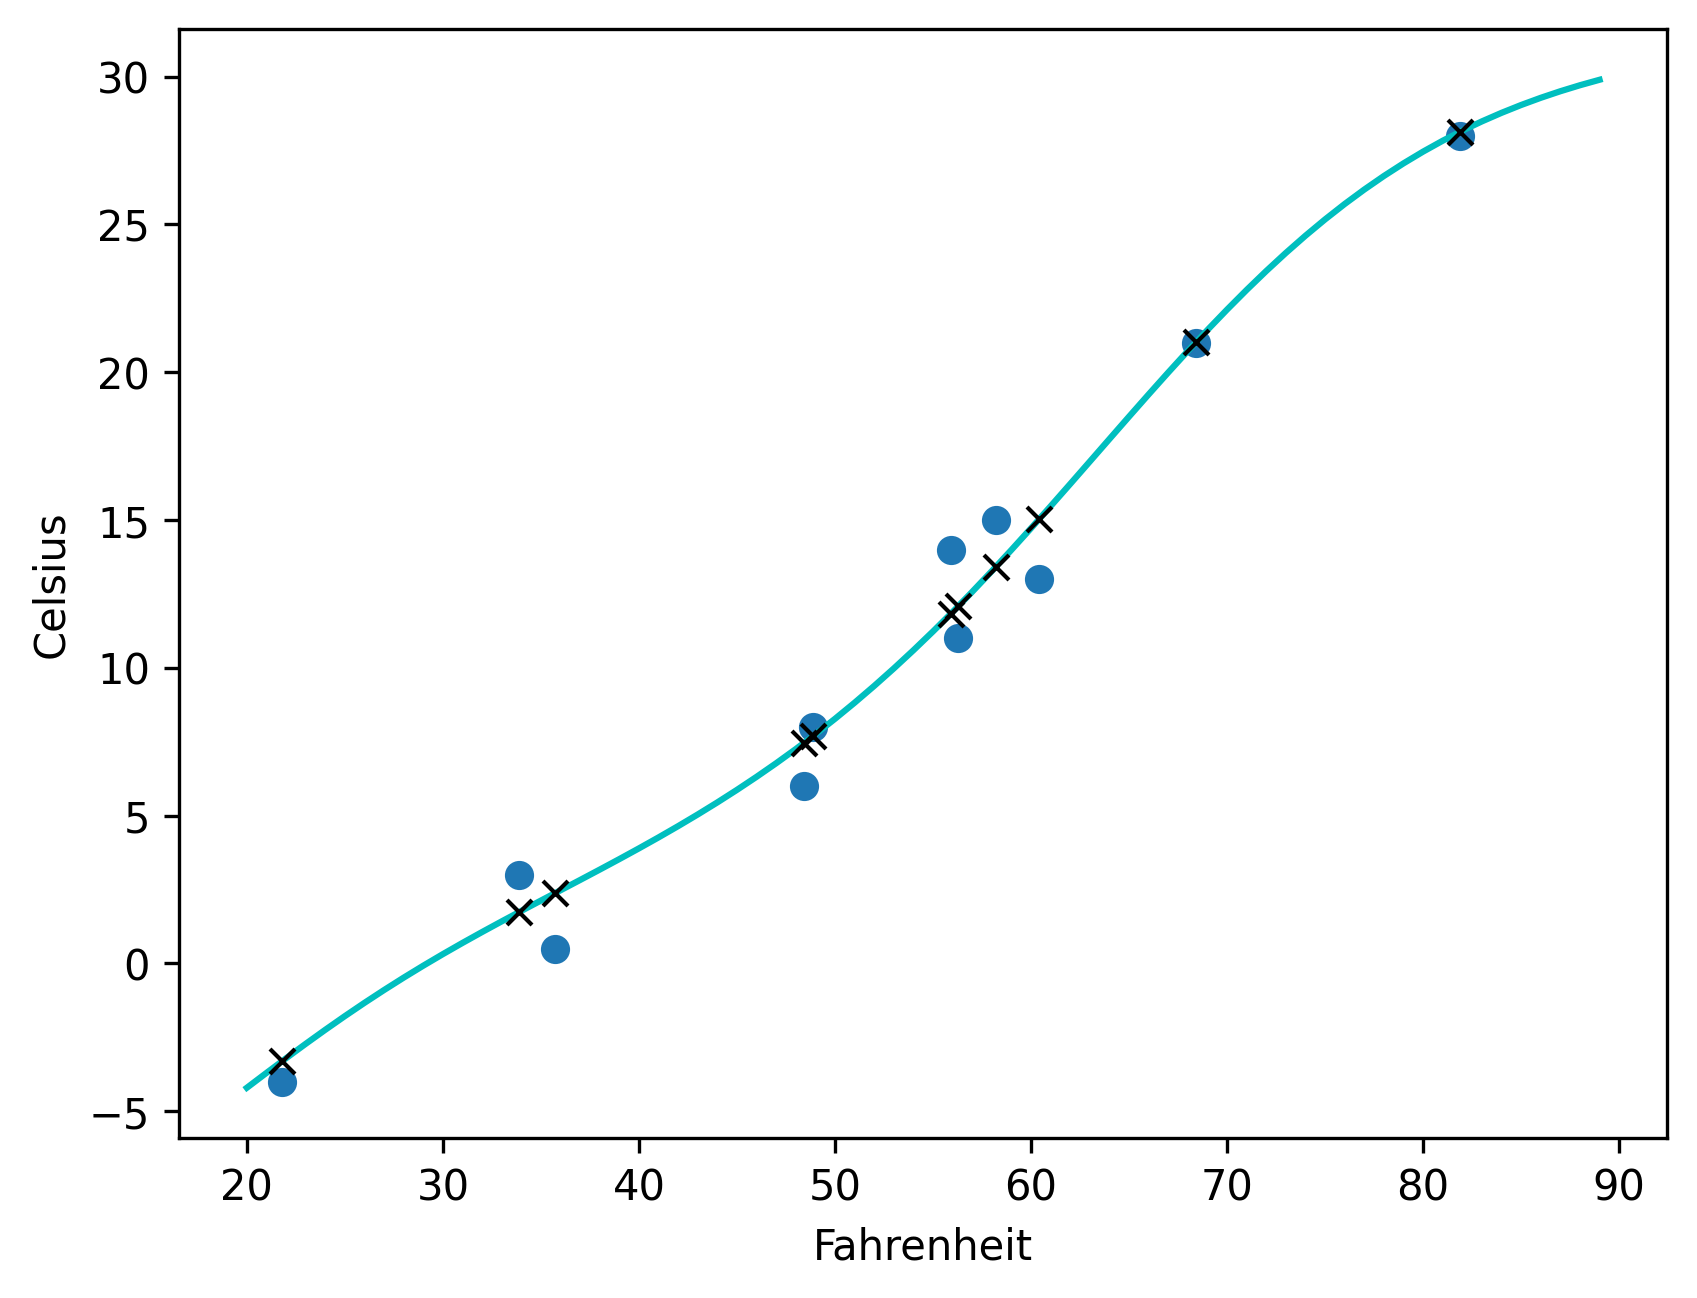

In [63]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=300)

plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')